# Viewing sharpley values  from dora xgboost 2 model

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.append("../dora/models/")
from utils import read_data, process_time, merge_data, promo_detector, promotionAggregation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import xgboost as xgb
from datetime import datetime

NUMBER_OF_LAGS = 4

## Preparing our dataset
These steps were already seen on ```../pre-processing-features``` notebooks.

In [2]:
infos, items, orders = read_data("../main/datasets/")
print("Sanity checks...", infos.shape, items.shape, orders.shape)

Sanity checks... (10463, 3) (10463, 8) (2181955, 5)


In [3]:
# Changing our time signatures, 
# adding our promotion feature 
# and aggregating our data by weeks...
process_time(orders)
orders = promo_detector(orders)
df = promotionAggregation(orders, items)

In [4]:
def prepareOrders(orders, items):
    """This function is responsible for adding in our 'orders' dataframe
    the items that were not sold. THIS IS NOT MODULARIZED, THUS YOU
    SHOULD CHANGE THE CODE TO BETTER SUIT YOUR DATASET FEATURES
    """
    
    df = orders.copy()
    
    # Getting the IDs that were never sold
    not_sold_items = items[np.logical_not(
        items.itemID.isin(sorted(orders['itemID'].unique())))]

    new_rows = []
    weeks_database = orders['group_backwards'].unique()

    for idd in df['itemID'].unique():
        orders_id = df[df.itemID == idd]
        example = orders_id.iloc[0]

        # finding weeks without itemID sales
        weeks_id = orders_id['group_backwards'].unique()
        weeks_without_id = np.setdiff1d(weeks_database, weeks_id)

        # creating new row
        for w in weeks_without_id:
            new_rows.append({'itemID': idd,
                             'group_backwards': w,
                             'salesPrice_mean': 0,
                             'customerRating': example['customerRating'],
                             'category1': example['category1'],
                             'category2': example['category2'],
                             'category3': example['category3'],
                             'recommendedRetailPrice': example['recommendedRetailPrice'],
                             'orderSum': 0,
                             'manufacturer': example['manufacturer'],
                             'brand': example['brand'],
                             'promotion_mean': 0
                             })
    #  Adding rows in every week with the IDs of the
    # items that were never sold.
    df = df.append(new_rows)
    not_sold_orders = pd.DataFrame()
    for i in range(1, 14):
        aux = not_sold_items.copy()
        aux['group_backwards'] = i
        aux['salesPrice_mean'] = 0
        aux['promotion_mean'] = 0
        aux['orderSum'] = 0
        not_sold_orders = pd.concat([not_sold_orders, aux], axis=0)
    df = pd.concat([df, not_sold_orders], axis=0).sort_values(
        ['group_backwards', 'itemID'], ascending=[False, True], ignore_index=True)
    return df

In [5]:
df = prepareOrders(df, items)

In [6]:
# This cell lags and diffs our features 'orderSum' and "promotion"

shifting = df.copy()

for i in range(NUMBER_OF_LAGS):
    #print(i)
    #print(f'promotion_mean_{i}')
    #print(shifting.groupby('itemID')['orderSum'].shift(0))
    #print(shifting.groupby('itemID')['orderSum'][0:20].shift(i))
    # Carrying the data of weeks t-1
    shifting[f'orderSum_{i}'] = shifting.groupby('itemID')['orderSum'].shift(i)
    shifting[f'promotion_mean_{i}'] = shifting.groupby('itemID')['promotion_mean'].shift(i)
    
    # Getting the difference of the orders and promotions between weeks t-1 and t-2...
    shifting[f'orderSum_diff_{i}'] = shifting.groupby('itemID')[f'orderSum_{i}'].diff()
    shifting[f'promotion_mean_diff_{i}'] = shifting.groupby('itemID')[f'promotion_mean_{i}'].diff()
    

## Maximum error
The maximum error we could get in this dataset would be just guessing the mean of our sales from weeks 1 to 12, and that's what the cell below is computing.

In [7]:
worst_possible_prediction = shifting.loc[shifting.group_backwards < 13]['orderSum'].mean()
prediction = np.full(shifting.loc[shifting.group_backwards == 13]['orderSum'].shape, worst_possible_prediction) # Array filled with the mean...
target = shifting.loc[shifting.group_backwards == 13]['orderSum']
print("Guessing the mean of 'orderSum' for all items in target", mse(target, prediction) ** 0.5)

Guessing the mean of 'orderSum' for all items in target 90.29706562119341


## Dataset Splitting
All my experiments will use weeks 13 to 3 as a train set, week 2 as our validation set and week 1 as a test set.

In [8]:
train = shifting.loc[shifting.group_backwards >= 3]
val = shifting.loc[shifting.group_backwards == 2]
test = shifting.loc[shifting.group_backwards == 1]

In [9]:
# I recommend to the other members of the team keeping the
# datatypes of our datasets as Pandas DataFrames instead of Numpy,
# since It will easier to use Boosting Analysis frameworks
y_train = train['orderSum']
y_val = val['orderSum']
X_train = train.drop(columns=["orderSum"])
X_val = val.drop(columns=["orderSum"])

In [10]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

param = {'max_depth':32, 'eta':0.01, 'objective':'reg:squarederror' }
num_round = 600
bst = xgb.train(param, dtrain,
                num_round, early_stopping_rounds = 5,
                evals = [(dtrain, 'train'), (dval, 'val')])

[0]	train-rmse:103.62440	val-rmse:110.20937
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 5 rounds.
[1]	train-rmse:102.61360	val-rmse:109.13287
[2]	train-rmse:101.61221	val-rmse:108.07217
[3]	train-rmse:100.62087	val-rmse:107.01550
[4]	train-rmse:99.63930	val-rmse:105.97206
[5]	train-rmse:98.66821	val-rmse:104.93466
[6]	train-rmse:97.70597	val-rmse:103.90665
[7]	train-rmse:96.75284	val-rmse:102.87869
[8]	train-rmse:95.80975	val-rmse:101.87131
[9]	train-rmse:94.87605	val-rmse:100.88046
[10]	train-rmse:93.95085	val-rmse:99.88320
[11]	train-rmse:93.03513	val-rmse:98.89206
[12]	train-rmse:92.12813	val-rmse:97.92736
[13]	train-rmse:91.23008	val-rmse:96.95738
[14]	train-rmse:90.34147	val-rmse:95.99724
[15]	train-rmse:89.46159	val-rmse:95.06122
[16]	train-rmse:88.58984	val-rmse:94.10953
[17]	train-rmse:87.72719	val-rmse:93.17948
[18]	train-rmse:86.87265	val-rmse:92.25472
[19]	train-rmse:86.02647	val-rmse:91.34

[186]	train-rmse:17.33421	val-rmse:17.41556
[187]	train-rmse:17.17401	val-rmse:17.24322
[188]	train-rmse:17.01538	val-rmse:17.07272
[189]	train-rmse:16.85831	val-rmse:16.90457
[190]	train-rmse:16.70308	val-rmse:16.73840
[191]	train-rmse:16.54911	val-rmse:16.57322
[192]	train-rmse:16.39669	val-rmse:16.40955
[193]	train-rmse:16.24568	val-rmse:16.24696
[194]	train-rmse:16.09688	val-rmse:16.08622
[195]	train-rmse:15.94895	val-rmse:15.92714
[196]	train-rmse:15.80248	val-rmse:15.76938
[197]	train-rmse:15.65744	val-rmse:15.61358
[198]	train-rmse:15.51381	val-rmse:15.45904
[199]	train-rmse:15.37202	val-rmse:15.30628
[200]	train-rmse:15.23121	val-rmse:15.15414
[201]	train-rmse:15.09203	val-rmse:15.00628
[202]	train-rmse:14.95401	val-rmse:14.85819
[203]	train-rmse:14.81737	val-rmse:14.71191
[204]	train-rmse:14.68204	val-rmse:14.56659
[205]	train-rmse:14.54862	val-rmse:14.42601
[206]	train-rmse:14.41600	val-rmse:14.28329
[207]	train-rmse:14.28464	val-rmse:14.14217
[208]	train-rmse:14.15503	val-rm

[379]	train-rmse:3.38771	val-rmse:2.69980
[380]	train-rmse:3.36268	val-rmse:2.67557
[381]	train-rmse:3.33791	val-rmse:2.65192
[382]	train-rmse:3.31332	val-rmse:2.62804
[383]	train-rmse:3.28900	val-rmse:2.60408
[384]	train-rmse:3.26486	val-rmse:2.58027
[385]	train-rmse:3.24092	val-rmse:2.55729
[386]	train-rmse:3.21719	val-rmse:2.53452
[387]	train-rmse:3.19370	val-rmse:2.51218
[388]	train-rmse:3.17042	val-rmse:2.48948
[389]	train-rmse:3.14730	val-rmse:2.46731
[390]	train-rmse:3.12442	val-rmse:2.44490
[391]	train-rmse:3.10171	val-rmse:2.42315
[392]	train-rmse:3.07919	val-rmse:2.40160
[393]	train-rmse:3.05692	val-rmse:2.38000
[394]	train-rmse:3.03481	val-rmse:2.35888
[395]	train-rmse:3.01290	val-rmse:2.33805
[396]	train-rmse:2.99117	val-rmse:2.31728
[397]	train-rmse:2.96968	val-rmse:2.29653
[398]	train-rmse:2.94834	val-rmse:2.27619
[399]	train-rmse:2.92718	val-rmse:2.25605
[400]	train-rmse:2.90623	val-rmse:2.23645
[401]	train-rmse:2.88543	val-rmse:2.21668
[402]	train-rmse:2.86482	val-rmse:

[575]	train-rmse:0.95921	val-rmse:0.70351
[576]	train-rmse:0.95379	val-rmse:0.70111
[577]	train-rmse:0.94841	val-rmse:0.69859
[578]	train-rmse:0.94306	val-rmse:0.69627
[579]	train-rmse:0.93775	val-rmse:0.69397
[580]	train-rmse:0.93246	val-rmse:0.69169
[581]	train-rmse:0.92722	val-rmse:0.68946
[582]	train-rmse:0.92201	val-rmse:0.68725
[583]	train-rmse:0.91683	val-rmse:0.68520
[584]	train-rmse:0.91169	val-rmse:0.68304
[585]	train-rmse:0.90658	val-rmse:0.68091
[586]	train-rmse:0.90150	val-rmse:0.67881
[587]	train-rmse:0.89646	val-rmse:0.67675
[588]	train-rmse:0.89145	val-rmse:0.67461
[589]	train-rmse:0.88647	val-rmse:0.67258
[590]	train-rmse:0.88153	val-rmse:0.67058
[591]	train-rmse:0.87661	val-rmse:0.66862
[592]	train-rmse:0.87173	val-rmse:0.66668
[593]	train-rmse:0.86687	val-rmse:0.66477
[594]	train-rmse:0.86205	val-rmse:0.66296
[595]	train-rmse:0.85726	val-rmse:0.66110
[596]	train-rmse:0.85250	val-rmse:0.65926
[597]	train-rmse:0.84777	val-rmse:0.65745
[598]	train-rmse:0.84307	val-rmse:

### Utilities

**Predicting at test time**

In [11]:
y_test = test['orderSum']
X_test = xgb.DMatrix(test.drop(columns=["orderSum"]))
final_predictions = bst.predict(X_test)

**Creating our Kaggle CSV**

In [12]:
final = pd.Series(0, index=np.arange(1, len(items)+1))
final[items.itemID] = np.rint(final_predictions)

final.to_csv("kaggle_df.csv", header=["demandPrediction"],
            index_label="itemID")

**Saving our model in disk**

In [13]:
now = datetime.now().strftime("%d-%m-%Y-%Hh%Mm%Ss")
modelName = 'xgb-' + now
bst.save_model(modelName)

## Sharpley values

In [14]:
import shap
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### looking average impact of every feature

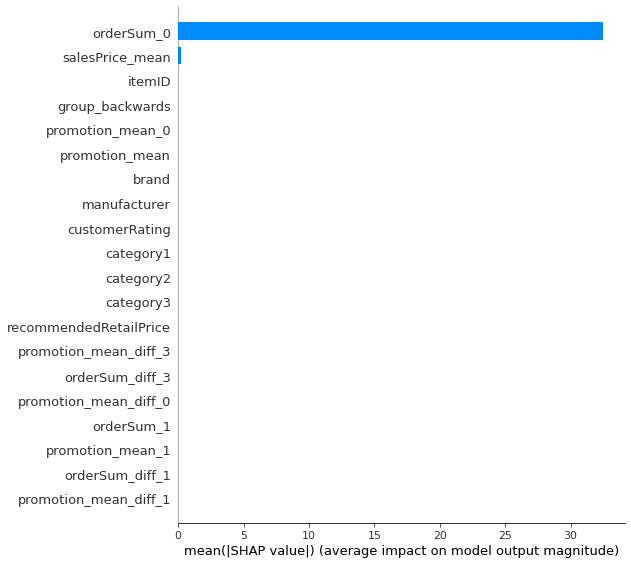

In [15]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

### overview of every feature influence

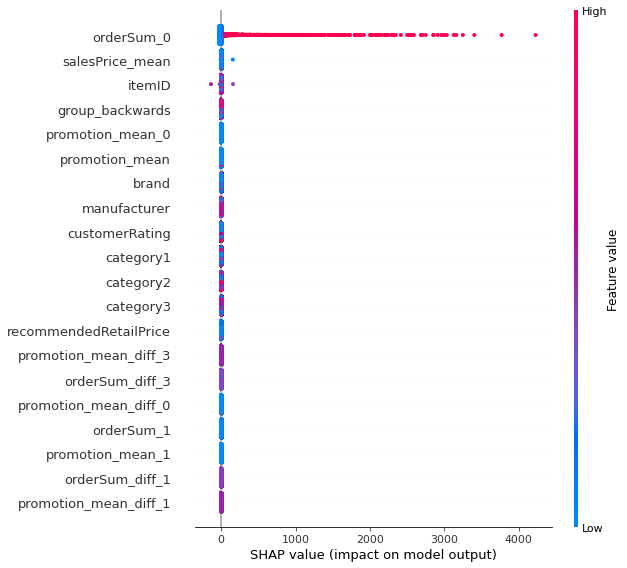

In [16]:
shap.summary_plot(shap_values, X_train)

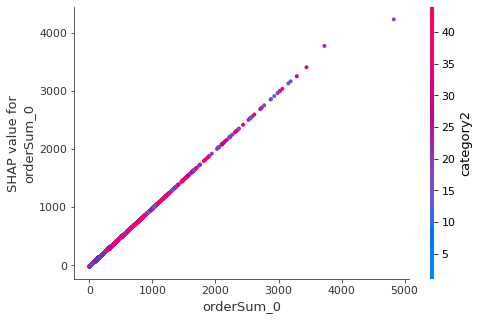

In [18]:
shap.dependence_plot("orderSum_0", shap_values, X_train)

## conclusions:

1- orderSum_0 is basically the only important feature, and that because it value is the same as the answer, the model has data leak

2- be careful with print(database), it doesn't show all the columns, the print below does not have orderSum_0

In [19]:
print(X_train)
print(X_train.columns)

        group_backwards  itemID  promotion_mean  salesPrice_mean  brand  \
0                    13       1             0.0             0.00    0.0   
1                    13       2             0.0             0.00    0.0   
2                    13       3             0.0            14.04    0.0   
3                    13       4             0.0             0.00    0.0   
4                    13       5             0.0             7.84    0.0   
...                 ...     ...             ...              ...    ...   
115088                3   10459             0.0             0.00  180.0   
115089                3   10460             0.0             0.00    0.0   
115090                3   10461             0.0             0.00    0.0   
115091                3   10462             0.0             0.00  180.0   
115092                3   10463             0.0           282.16    0.0   

        manufacturer  customerRating  category1  category2  category3  ...  \
0                1.0 

In [23]:
pd.options.display.max_columns = None
display(X_train)

,group_backwards,itemID,promotion_mean,salesPrice_mean,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,orderSum_0,promotion_mean_0,orderSum_diff_0,promotion_mean_diff_0,orderSum_1,promotion_mean_1,orderSum_diff_1,promotion_mean_diff_1,orderSum_2,promotion_mean_2,orderSum_diff_2,promotion_mean_diff_2,orderSum_3,promotion_mean_3,orderSum_diff_3,promotion_mean_diff_3
0,13,1,0.0,0.00,0.0,1.0,4.38,1.0,1.0,1.0,8.84,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2,0.0,0.00,0.0,2.0,3.00,1.0,2.0,1.0,16.92,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,3,0.0,14.04,0.0,3.0,5.00,1.0,3.0,1.0,15.89,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,4,0.0,0.00,0.0,2.0,4.44,1.0,2.0,1.0,40.17,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,5,0.0,7.84,0.0,2.0,2.33,1.0,1.0,1.0,17.04,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115088,3,10459,0.0,0.00,180.0,253.0,0.00,8.0,44.0,8.0,56.57,0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115089,3,10460,0.0,0.00,0.0,253.0,0.00,8.0,44.0,8.0,163.81,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0
115090,3,10461,0.0,0.00,0.0,253.0,0.00,8.0,44.0,8.0,128.01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
115091,3,10462,0.0,0.00,180.0,253.0,0.00,8.0,44.0,8.0,166.97,0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
